<a href="https://colab.research.google.com/github/Kush-Singh-26/Micrograd/blob/main/MicroGrad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making micrograd from scratch

In [723]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

In [724]:
def f(x):
  return 3*x**2 + 4*x - 5

In [725]:
f(4.0)

59.0

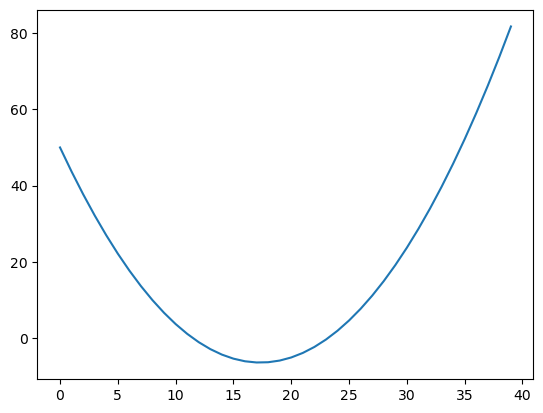

In [726]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(ys)

In [727]:
h = 0.0000001
x = 4
slope = (f(x+h) - f(x)) / h

In [728]:
slope

28.000000469319275

In [729]:
class Tensor:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backprop = lambda: None

  def __repr__(self):
    return f"Tensor(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Tensor) else Tensor(other)
    out = Tensor(self.data + other.data, (self, other), '+')

    def _backprop():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backprop = _backprop

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Tensor) else Tensor(other)   # to allow opertations like (a * 2) or (a + 1)
    out = Tensor(self.data * other.data, (self, other), '*')

    def _backprop():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backprop = _backprop

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Tensor(t, (self, ), 'tanh')

    def _backprop():
      self.grad += (1 - t**2) * out.grad
    out._backprop = _backprop

    return out
  
  def relu(self):
    out = Tensor(0 if self.data < 0 else self.data, (self, ), 'ReLU')

    def _backprop():
      self.grad += (out.data > 0) * out.grad
    out._backprop = _backprop

    return out

  def backprop(self):
    topo = []
    visited = set()

    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    build_topo(self)    # builds the topoloical graph

    self.grad = 1.0
    for node in reversed(topo):
      node._backprop()

  def __radd__(self, other):    # to perform operations like 2 + a
    return self + other

  def __rmul__(self, other):
    return self * other

  def exp(self):
    x = self.data
    out = Tensor(math.exp(x), (self, ), 'exp')

    def _backprop():
      self.grad += out.data * out.grad

    out._backprop = _backprop

    return out

  def pow(self, other):
    assert isinstance(other, (int, float)), "only float or int can be exponent"
    out = Tensor(self.data**other, (self,), f'**{other}')

    def _backprop():
      self.grad += (other * self.data ** (other -1)) * out.grad
    out._backprop = _backprop

    return out

  def _truediv__(self,other):
    return self * other**-1

  def __neg__(self):
    return self * -1
  
  def __sub__(self, other):
    return self + (-other)
  
  def __rsub__(self, other):
    return other + (-self)
  
  def __rtruediv__(self, other):
    return other * self**-1
  
  def __pow__(self, other):
    return self.pow(other)

In [730]:
a = Tensor(2.0 , label = 'a')
2 + a
a.exp()

Tensor(data=7.38905609893065)

- `_children()` is used to store the bodes that were used to compute this `Tensor` instance
- It is converted to a set and strored in `_prev` attribute
- `label` is added just for the graph not needed in the actual model



$$ tanh(x) = \frac{e^{2x}-1}{e^{2x}+1} $$

- Lambda function in python :  
A lambda function in Python is an anonymous function that is defined using the lambda keyword. Unlike normal functions defined using def, lambda functions can have only one expression but can take multiple arguments.
- `lambda arguments: expression`

In [731]:
a = Tensor(2.0, label='a')
b = Tensor(-3.0, label='b')
c = Tensor(10.0, label='c')
e = a*b
e.label = 'e'
d = e +c
d.label = 'd'
f = Tensor(-2.0, label = 'f')
L = d * f; L.label = 'L'
L

Tensor(data=-8.0)

`a*b + c` = `(a.__mul__(b)).__add__(c)`

In [732]:
d._prev

{Tensor(data=-6.0), Tensor(data=10.0)}

In [733]:
d._op

'+'

In [734]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any Tensor in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this Tensor is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

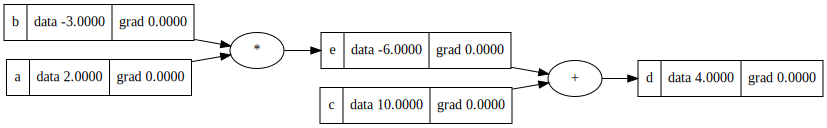

In [735]:
draw_dot(d)

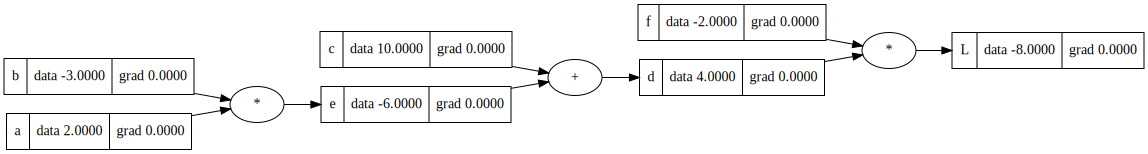

In [736]:
draw_dot(L)

## Manual Backpropdagation
derivative of L with respect to L =  1

In [737]:
def mandef():

  h = 0.001

  a = Tensor(2.0, label='a')
  b = Tensor(-3.0, label='b')
  c = Tensor(10.0, label='c')
  e = a*b
  e.label = 'e'
  d = e + c
  d.label = 'd'
  f = Tensor(-2.0, label = 'f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Tensor(2.0 , label='a')
  b = Tensor(-3.0, label='b')
  c = Tensor(10.0, label='c')
  e = a*b
  e.label = 'e'
  d = e +c
  d.label = 'd'
  f = Tensor(-2.0, label = 'f')
  L = d * f; L.label = 'L'
  L2 = L.data + h       # increased the value of L by h

  print((L2 - L1) / h)

mandef()

1.000000000000334


- Therefore Derivative of L with L = 1

In [738]:
L.grad = 1.0  # manually setting the value of dervative of  with LL

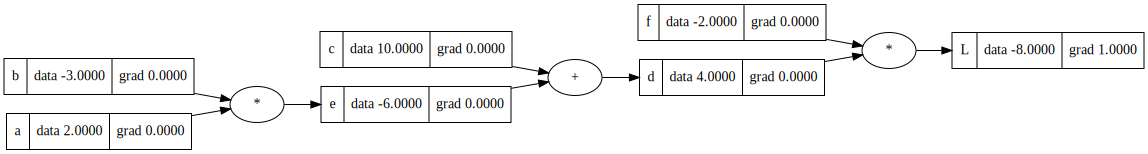

In [739]:
draw_dot(L)

- L = d * f
- derivative of L w.r.t f = dL/df  = d
- by symmetry dL/dd = f

In [740]:
# Derivative of f
def mandef():

  h = 0.001

  a = Tensor(2.0, label='a')
  b = Tensor(-3.0, label='b')
  c = Tensor(10.0, label='c')
  e = a*b
  e.label = 'e'
  d = e + c
  d.label = 'd'
  f = Tensor(-2.0, label = 'f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Tensor(2.0 , label='a')
  b = Tensor(-3.0, label='b')
  c = Tensor(10.0, label='c')
  e = a*b
  e.label = 'e'
  d = e +c
  d.label = 'd'
  f = Tensor(-2.0 + h, label = 'f')   # inc value of f
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1) / h)

mandef()

3.9999999999995595


In [741]:
# Derivative of d
def mandef():

  h = 0.001

  a = Tensor(2.0, label='a')
  b = Tensor(-3.0, label='b')
  c = Tensor(10.0, label='c')
  e = a*b
  e.label = 'e'
  d = e + c
  d.label = 'd'
  f = Tensor(-2.0, label = 'f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Tensor(2.0 , label='a')
  b = Tensor(-3.0, label='b')
  c = Tensor(10.0, label='c')
  e = a*b
  e.label = 'e'
  d = e +c
  d.data += h
  d.label = 'd'
  f = Tensor(-2.0 , label = 'f')   # inc value of f
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1) / h)

mandef()

-2.000000000000668


In [742]:
f.grad = 4.0  # = d
d.grad = -2.0 # = f

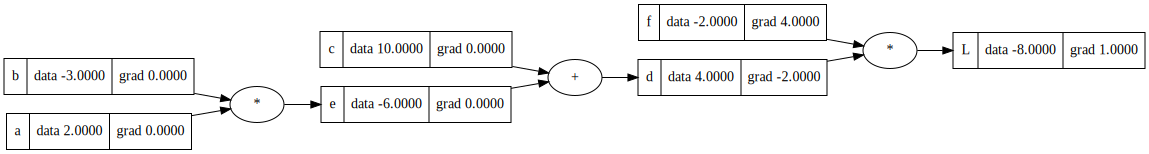

In [743]:
draw_dot(L)

## Derivation of dL/dc

$$ d = c + e $$

Then:

$$ \frac{dd}{dc} = 1, \quad \frac{dd}{de} = 1 $$

By the **chain rule**:

If a variable z depends on the variable y, which itself depends on the variable x (that is, y and z are dependent variables), then z depends on x as well, via the intermediate variable y. In this case, the chain rule is expressed as :

$$ \frac{dz}{dx} = \frac{dz}{dy} * \frac{dy}{dx} $$

therfore : <br>
 $$ \frac{dL}{dc} = \frac{dL}{dd} * \frac{dd}{dc} $$   

 <br>
 $$ \frac{dL}{dc} = 1 * (-2.0) $$     <br>
 $$ \frac{dL}{dc} = -2.0 $$

 - Similarly $$ \frac{dL}{de} =  -2.0 $$


In [744]:
c.grad = -2.0
e.grad = -2.0

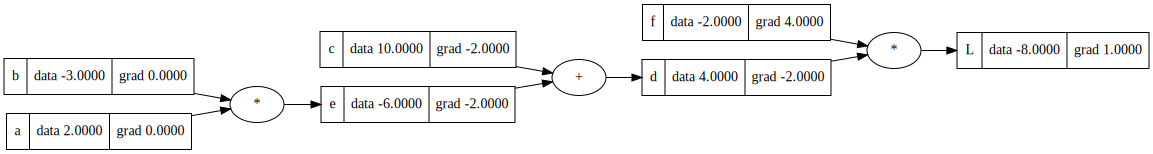

In [745]:
draw_dot(L)

> Thus a `+` node will distribute the derivative to all the children nodes
because derivative of an expression with '+' = 1.

In [746]:
def mandef():

  h = 0.001

  a = Tensor(2.0, label='a')
  b = Tensor(-3.0, label='b')
  c = Tensor(10.0, label='c')
  e = a*b
  e.label = 'e'
  d = e + c
  d.label = 'd'
  f = Tensor(-2.0, label = 'f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Tensor(2.0 , label='a')
  b = Tensor(-3.0, label='b')
  c = Tensor(10.0, label='c')
  e = a*b
  e.data += h   # inc value of e
  e.label = 'e'
  d = e +c

  d.label = 'd'
  f = Tensor(-2.0 , label = 'f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1) / h)

mandef()

-2.000000000000668


In [747]:
def mandef():

  h = 0.001

  a = Tensor(2.0, label='a')
  b = Tensor(-3.0, label='b')
  c = Tensor(10.0, label='c')
  e = a*b
  e.label = 'e'
  d = e + c
  d.label = 'd'
  f = Tensor(-2.0, label = 'f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Tensor(2.0 , label='a')
  b = Tensor(-3.0, label='b')
  c = Tensor(10.0 + h, label='c') # inc value of c
  e = a*b
  e.label = 'e'
  d = e +c

  d.label = 'd'
  f = Tensor(-2.0 , label = 'f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1) / h)

mandef()

-1.9999999999988916


## Derivation of dL/da
from chain rule :

$$ \frac{dL}{da} = \frac{dL}{dd} * \frac{dd}{de} * \frac{de}{da} $$ 
$$ = \frac{dL}{de} * \frac{de}{da}$$



  $$ e = a * b $$
$$\frac{de}{da} = b, \quad  \frac{de}{db} = a $$

In [748]:
a.grad = -2.0 * -3.0  # dL/de * b
b.grad = -2.0 * 2.0   # dL/db * a

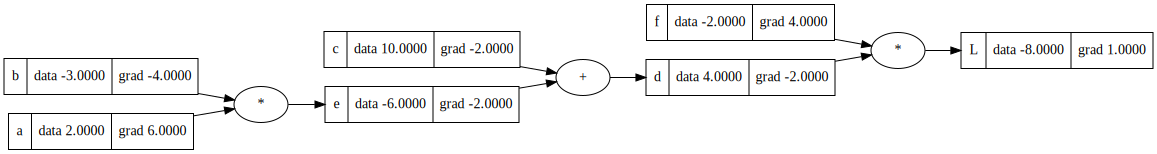

In [749]:
draw_dot(L)

In [750]:
def mandef():

  h = 0.001

  a = Tensor(2.0, label='a')
  b = Tensor(-3.0, label='b')
  c = Tensor(10.0, label='c')
  e = a*b
  e.label = 'e'
  d = e + c
  d.label = 'd'
  f = Tensor(-2.0, label = 'f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Tensor(2.0 + h, label='a') # inc value of a
  b = Tensor(-3.0, label='b')
  c = Tensor(10.0, label='c')
  e = a*b
  e.label = 'e'
  d = e +c

  d.label = 'd'
  f = Tensor(-2.0 , label = 'f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1) / h)

mandef()

6.000000000000227


In [751]:
def mandef():

  h = 0.001

  a = Tensor(2.0, label='a')
  b = Tensor(-3.0, label='b')
  c = Tensor(10.0, label='c')
  e = a*b
  e.label = 'e'
  d = e + c
  d.label = 'd'
  f = Tensor(-2.0, label = 'f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Tensor(2.0 , label='a')
  b = Tensor(-3.0 + h, label='b') # inc value of b
  c = Tensor(10.0, label='c')
  e = a*b
  e.label = 'e'
  d = e +c

  d.label = 'd'
  f = Tensor(-2.0 , label = 'f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1) / h)

mandef()

-3.9999999999995595


- Single Optimization step

In [752]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


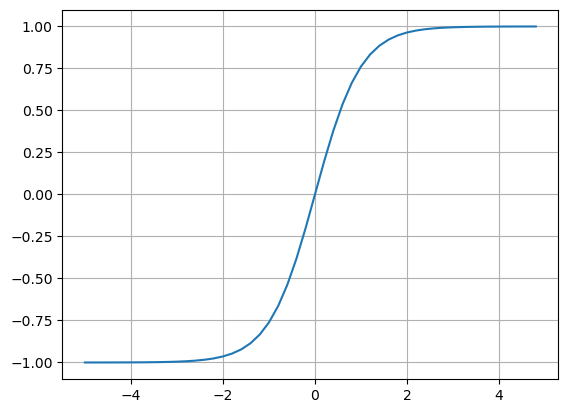

In [753]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

In [754]:
# inputs x1,x2
x1 = Tensor(2.0, label='x1')
x2 = Tensor(0.0, label='x2')
# weights w1,w2
w1 = Tensor(-3.0, label='w1')
w2 = Tensor(1.0, label='w2')
# bias of the neuron
b = Tensor(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

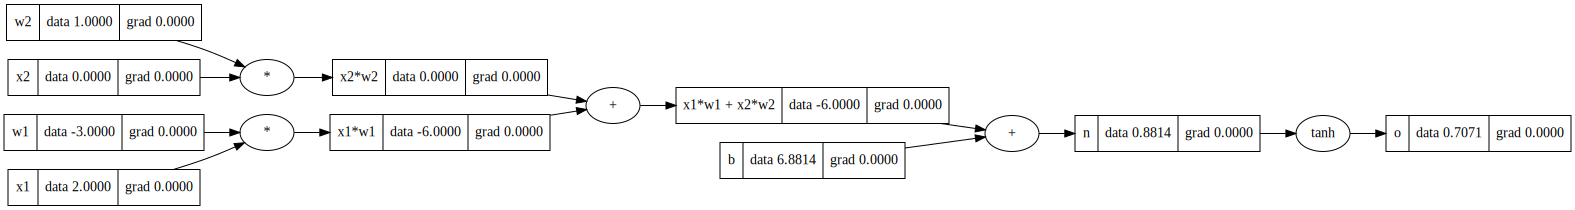

In [755]:
draw_dot(o)

## Backpropagation of the above neuron

In [756]:
o.grad = 1.0

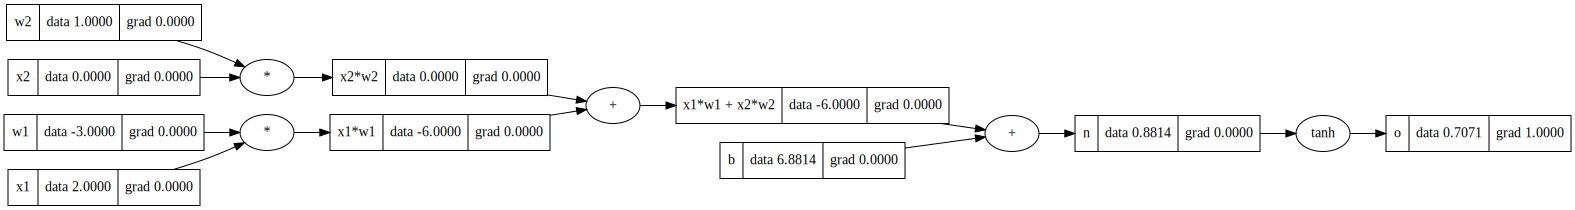

In [757]:
draw_dot(o)

$$ \frac {d}{dx} tanh(x) = 1 - tanh^{2}x $$

In [758]:
o.data

0.7071067811865476

In [759]:
1 - o.data**2

0.4999999999999999

In [760]:
n.grad = 0.5

> grad of `+` node will distribute the gradient to the children node

In [761]:
b.grad = 0.5
x1w1x2w2.grad = 0.5

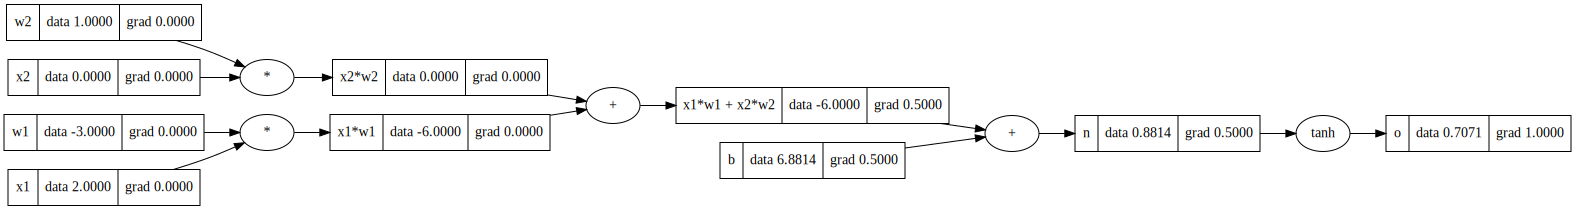

In [762]:
draw_dot(o)

In [763]:
x1w1.grad = 0.5
x2w2.grad = 0.5

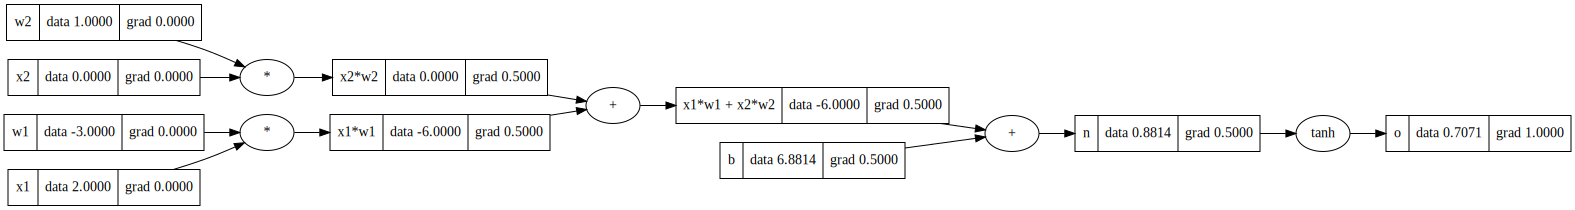

In [764]:
draw_dot(o)

In [765]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [766]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

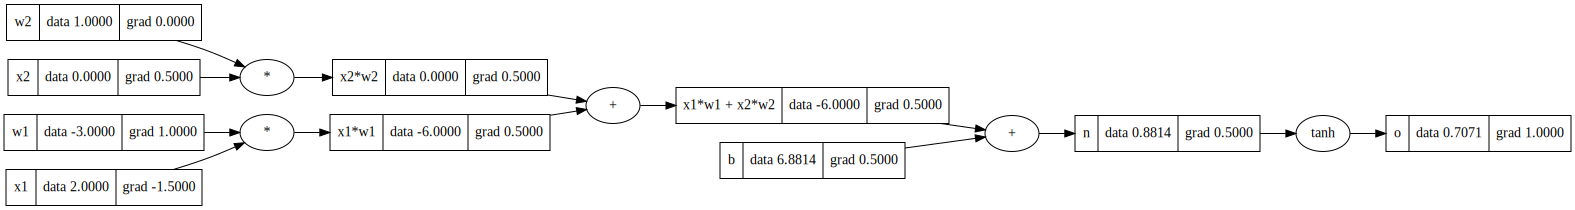

In [767]:
draw_dot(o)

## Automatic Backpropagation

In [768]:
# inputs x1,x2
x1 = Tensor(2.0, label='x1')
x2 = Tensor(0.0, label='x2')
# weights w1,w2
w1 = Tensor(-3.0, label='w1')
w2 = Tensor(1.0, label='w2')
# bias of the neuron
b = Tensor(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

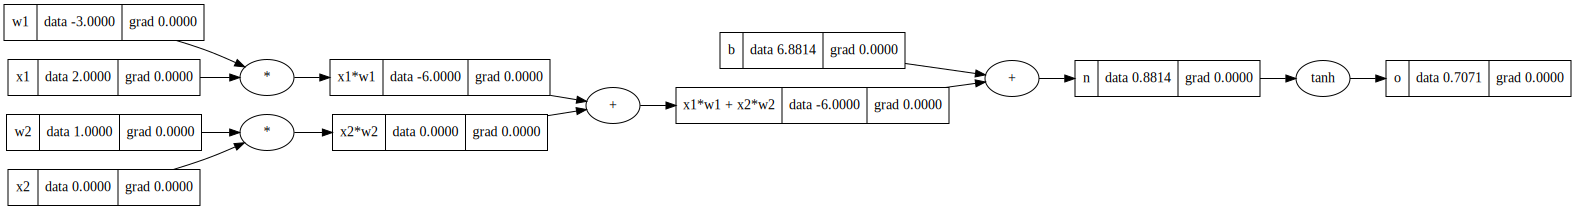

In [769]:
draw_dot(o)

In [770]:
o.grad = 1.0

In [771]:
o._backprop()

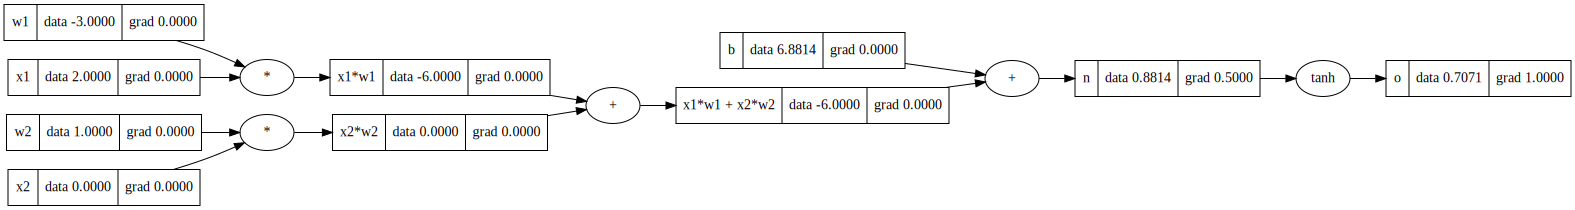

In [772]:
draw_dot(o)

In [773]:
n._backprop()
x1w1x2w2._backprop()
x1w1._backprop()
x2w2._backprop()

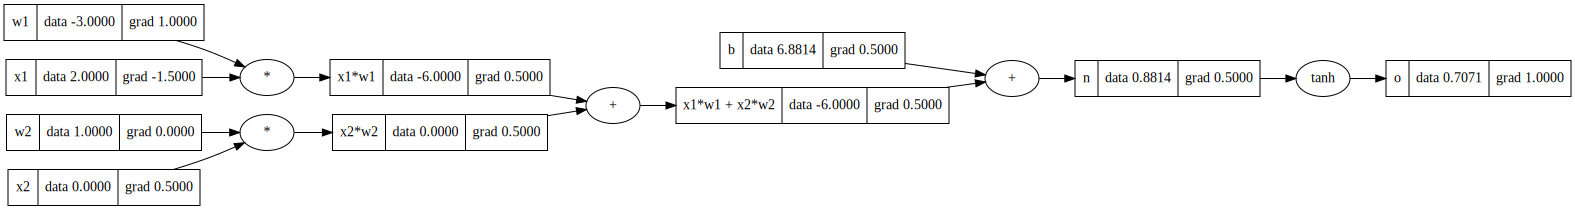

In [774]:
draw_dot(o)

In [775]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Tensor(data=6.881373587019543),
 Tensor(data=1.0),
 Tensor(data=0.0),
 Tensor(data=0.0),
 Tensor(data=2.0),
 Tensor(data=-3.0),
 Tensor(data=-6.0),
 Tensor(data=-6.0),
 Tensor(data=0.8813735870195432),
 Tensor(data=0.7071067811865476)]

In [776]:
for node in topo :
  node.grad = 0

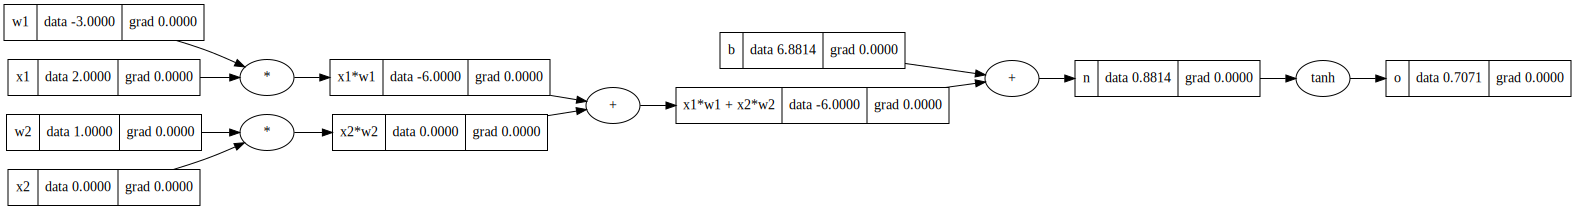

In [777]:
draw_dot(o)

### Automatic backprop

In [778]:
o.backprop()

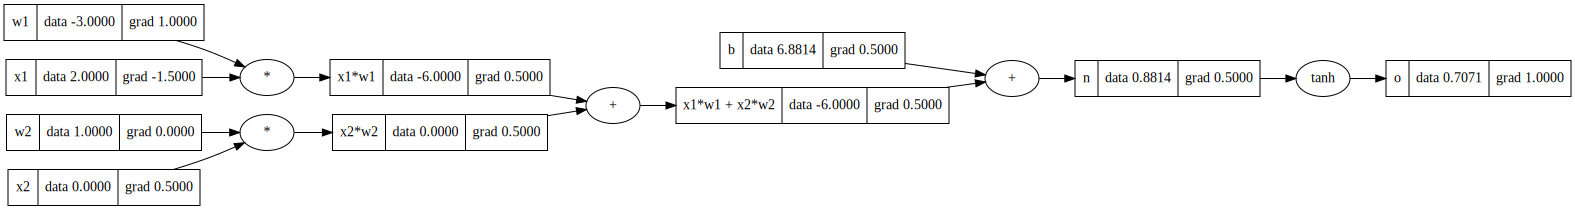

In [779]:
draw_dot(o)

In [780]:
class Neuron:

    def __init__(self, nin):    # nin = no. of inputs
        self.w = [Tensor(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Tensor(random.uniform(-1,1))
    
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
       return self.w + [self.b]   # [self.b] because w is alreadt a list and [self.b] will concatenate both list

class Layer:
  
  def __init__(self, nin, nout):        # nout = no. of outputs = no. of neurons
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
  def __init__(self, nin, nouts):    # nouts = this is a list which defines sizes of all the neurons
      sz = [nin] + nouts
      self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
     return [p for layer in self.layers for p in layer.parameters()]


- `act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)`  
is equivalent to      
`act = sum(wi * xi for wi, xi in zip(self.w, x)) + self.b`

- `zip(self.w, x)` pairs corresponding self.w (weights) and x (input features)
- `sum(..., self.b)` initializes the sum with self.b or the bias

In [781]:
x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Tensor(data=0.6124652628442534),
 Tensor(data=-0.07488210291833126),
 Tensor(data=-0.9415733075510124)]

![Pictorial representation](img/image.png)

In [782]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1]) 
n(x)

Tensor(data=-0.8718729600999537)

- `x = [2.0, 3.0, -1.0]`
    - this defines a vector x which is the input to this mlp
- `n = MLP(3, [4, 4, 1])`
    - defines a MLP with :
        - 3 inputs in the input layer
        - 3 layers (`[4, 4, 1]`) in which forst 2 layes have 4 neurons and the last output layer has 1 neuron

![MLP representation](img/img-mlp.png)

In [ ]:
draw_dot(n(x)) # not running it here beause of very large size image

In [784]:
n.parameters()

[Tensor(data=-0.8227414708133352),
 Tensor(data=0.8290913413137253),
 Tensor(data=-0.5106672021542924),
 Tensor(data=0.1749254183291622),
 Tensor(data=-0.922777093473039),
 Tensor(data=0.27259491424780213),
 Tensor(data=-0.052639552850185733),
 Tensor(data=0.4605382266442841),
 Tensor(data=0.35976044371980764),
 Tensor(data=-0.331885283304278),
 Tensor(data=-0.9360848596655402),
 Tensor(data=-0.041828549580545715),
 Tensor(data=-0.9024573038897878),
 Tensor(data=0.006257783282995533),
 Tensor(data=0.3204382483735435),
 Tensor(data=-0.35820779890713994),
 Tensor(data=0.9486832636124032),
 Tensor(data=-0.5984125601785542),
 Tensor(data=0.12570721338570312),
 Tensor(data=-0.20907593984329442),
 Tensor(data=-0.027542600778499793),
 Tensor(data=-0.08549640670854353),
 Tensor(data=0.9471850181064978),
 Tensor(data=-0.672914024830269),
 Tensor(data=0.5107932817039254),
 Tensor(data=-0.37413438129414156),
 Tensor(data=0.4985197556018859),
 Tensor(data=0.05728284412747531),
 Tensor(data=-0.8383

In [785]:
len(n.parameters())

41

In [786]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

- want the nn to print 1.0 when input = `[2.0, 3.0, -1.0]`
- want the nn to print -1.0 whrn input = `[0.5, 1.0, 1.0]`

In [787]:

ypred = [n(x) for x in xs]
ypred

[Tensor(data=-0.8718729600999537),
 Tensor(data=-0.9732058614945079),
 Tensor(data=-0.45632689182216213),
 Tensor(data=-0.9092228414543974)]

- **loss** : it is a single number which defines how well the neeural net is performing

- using **Mean Squared Error Loss**
    - it is the square of the difference between the actual value and the predited value

In [788]:
[(yout - ygt).pow(2) for ygt, yout in zip(ys, ypred)]   # ygt = y ground truth, i.e. the actual values of y (output)

[Tensor(data=3.503908378753363),
 Tensor(data=0.0007179258582514922),
 Tensor(data=0.295580448555751),
 Tensor(data=3.645131858331203)]

- more off the prediction is from the target value the higher the loss will be

In [789]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Tensor(data=7.445338611498569)

In [790]:
n.layers[0].neurons[0].w[0].grad

0.0

In [791]:
loss.backprop()

In [792]:
n.layers[0].neurons[0].w[0].grad

-0.0698697160080268

In [793]:
n.layers[0].neurons[0].w[0].data

-0.8227414708133352

## Gradient descent
$$ p  = p +  (- alpa * grad) $$

- Because gradient points in the direction of increasing loss
- We want to minimize it 
- Therefore subtract the grad * alpha
- alpha = learning rate 

In [794]:
alpha = 0.01
for p in n.parameters():
    p.data += - alpha * p.grad

In [795]:
n.layers[0].neurons[0].w[0].data

-0.8220427736532548

In [796]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Tensor(data=7.327899579559682)

- Earlier loss = 6.4672354048949
- Now loss =  6.209114361181134

- Therefore loss decreased after parmater updates

In [797]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0    #  resetting the grad everytime so they dont keep on adding up
  loss.backprop()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 7.327899579559682
1 5.343057733301688
2 1.340815417582868
3 0.7441209965964444
4 0.3002278553346825
5 0.1640044380247788
6 0.12718659080967035
7 0.10316011808938455
8 0.08632539829329307
9 0.0739303294566997
10 0.0644574544579763
11 0.05700367957930899
12 0.05099949172364661
13 0.046068844782511255
14 0.04195394835447055
15 0.03847247522414935
16 0.03549201955914542
17 0.03291422613517348
18 0.030664584792922216
19 0.028685670641422627


In [798]:
ypred

[Tensor(data=0.9225960150168561),
 Tensor(data=-0.9249555495134976),
 Tensor(data=-0.9062747645333968),
 Tensor(data=0.9090153615270109)]

In [799]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0    #  resetting the grad everytime so they dont keep on adding up
  loss.backprop()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

ypred

0 0.02693254939183483
1 0.02536958245331008
2 0.023968160021644522
3 0.022705063311656795
4 0.021561261956651104
5 0.020521017887490618
6 0.01957120861744423
7 0.01870080995241965
8 0.01790049613005596
9 0.017162327540674552
10 0.016479504524797434
11 0.015846171555032103
12 0.015257260217097595
13 0.014708362343468794
14 0.014195626780858466
15 0.013715674830358099
16 0.013265530551061205
17 0.012842562978238672
18 0.012444437955330562
19 0.012069077771586527


[Tensor(data=0.9499806417022211),
 Tensor(data=-0.9489750097468512),
 Tensor(data=-0.9417581606059597),
 Tensor(data=0.9402381385771006)]

In [800]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0    #  resetting the grad everytime so they dont keep on adding up
  loss.backprop()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

ypred

0 0.011714627174489466
1 0.011379424617289207
2 0.011061977828310154
3 0.010760942965810618
4 0.010475106761654765
5 0.01020337116756886
6 0.009944740105820438
7 0.00969830799671926
8 0.009463249792171922
9 0.009238812290526668
10 0.009024306545358707
11 0.008819101211415057
12 0.008622616696021249
13 0.008434320004920502
14 0.00825372018861381
15 0.008080364309469458
16 0.00791383386170533
17 0.007753741586247599
18 0.007599728630777848
19 0.007451462012278125


[Tensor(data=0.9607356965469098),
 Tensor(data=-0.9587717632579904),
 Tensor(data=-0.9555098068018228),
 Tensor(data=0.9527704362612203)]

In [801]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0    #  resetting the grad everytime so they dont keep on adding up
  loss.backprop()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

ypred

0 0.007308632345292789
1 0.007170951804134511
2 0.007038152291516691
3 0.006909983789720815
4 0.006786212873506732
5 0.006666621366628002
6 0.00655100512609548
7 0.006439172940295997
8 0.006330945528767641
9 0.006226154632899942
10 0.006124642188098807
11 0.006026259569060483
12 0.005930866900761614
13 0.005838332428611795
14 0.00574853194194923
15 0.0056613482457028895
16 0.005576670675609749
17 0.0054943946528709636
18 0.005414421274569132
19 0.005336656936553191


[Tensor(data=0.9667902380975628),
 Tensor(data=-0.964425507743441),
 Tensor(data=-0.9631267624324062),
 Tensor(data=0.9598927873954267)]

In [802]:
for k in range(30):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0    #  resetting the grad everytime so they dont keep on adding up
  loss.backprop()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

ypred

0 0.005261012985840099
1 0.0051874053998824474
2 0.005115754490320357
3 0.00504598462907258
4 0.004978023994833771
5 0.004911804338232842
6 0.004847260764075285
7 0.004784331529242895
8 0.004722957854957563
9 0.004663083752236785
10 0.004604655859476524
11 0.004547623291192426
12 0.004491937497039864
13 0.004437552130308786
14 0.0043844229251625896
15 0.0043325075819520996
16 0.004281765659994124
17 0.004232158477256233
18 0.00418364901643593
19 0.004136201836965613
20 0.004089782992513266
21 0.004044359953584254
22 0.003999901534860869
23 0.003956377826946572
24 0.003913760132207206
25 0.0038720209044264334
26 0.0038311336920142385
27 0.0037910730845279916
28 0.0037518146622831424
29 0.0037133349488487144


[Tensor(data=0.9723166187388604),
 Tensor(data=-0.9697003828022671),
 Tensor(data=-0.9699602283418582),
 Tensor(data=0.966436468195426)]

In [803]:
for k in range(50):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0    #  resetting the grad everytime so they dont keep on adding up
  loss.backprop()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

ypred

0 0.0036756113662367767
1 0.0036386221926104226
2 0.003602346522347063
3 0.003566764228306054
4 0.003531855926160276
5 0.003497602940662042
6 0.0034639872737220545
7 0.0034309915741893675
8 0.0033985991092279812
9 0.0033667937371925625
10 0.0033355598819131633
11 0.0033048825083043312
12 0.0032747470992201305
13 0.0032451396334816
14 0.003216046565008327
15 0.003187454802989975
16 0.0031593516930382708
17 0.0031317249992632596
18 0.00310456288722184
19 0.0030778539076893475
20 0.003051586981208649
21 0.0030257513833736012
22 0.003000336730806631
23 0.0029753329677926757
24 0.0029507303535341533
25 0.0029265194499935388
26 0.002902691110292245
27 0.0028792364676367066
28 0.0028561469247436453
29 0.0028334141437388553
30 0.0028110300365049193
31 0.0027889867554547866
32 0.002767276684709577
33 0.002745892431660177
34 0.0027248268188933868
35 0.0027040728764642624
36 0.002683623834497784
37 0.002663473116103434
38 0.0026436143305874895
39 0.002624041266948508
40 0.002604747887642582
41 0.

[Tensor(data=0.9775691082514189),
 Tensor(data=-0.9748420419154177),
 Tensor(data=-0.9763124587584311),
 Tensor(data=0.9726941714552314)]

In [804]:
i = -1
for k in range(200):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0    #  resetting the grad everytime so they dont keep on adding up
  loss.backprop()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  i = i+1
  if(i%5 == 0):
    print(k, loss.data)

ypred

0 0.0024259812234496366
5 0.0023452711493495136
10 0.002269627386051364
15 0.002198593044439566
20 0.002131764180824579
25 0.0020687823799871554
30 0.0020093285468056887
35 0.001953117683372892
40 0.0018998944742686064
45 0.001849429538137434
50 0.0018015162314224376
55 0.001755967911877189
60 0.0017126155866942854
65 0.0016713058837830542
70 0.0016318992956829443
75 0.001594268654408837
80 0.0015582978026451133
85 0.0015238804324885047
90 0.0014909190676595638
95 0.0014593241689705328
100 0.0014290133460212037
105 0.0013999106607263945
110 0.00137194601046127
115 0.0013450545804295508
120 0.0013191763563795166
125 0.0012942556900670697
130 0.0012702409109378238
135 0.0012470839784063186
140 0.0012247401698763797
145 0.0012031678002988652
150 0.0011823279696173002
155 0.001162184334926
160 0.0011427029045710836
165 0.0011238518517734091
170 0.0011056013456523313
175 0.0010879233977880475
180 0.0010707917226845543
185 0.001054181610688699
190 0.0010380698120902234
195 0.0010224344312741

[Tensor(data=0.9856207828077649),
 Tensor(data=-0.9830574906519951),
 Tensor(data=-0.9856685120511581),
 Tensor(data=0.9823633001489313)]

In [805]:
n.parameters()

[Tensor(data=-0.763722492584268),
 Tensor(data=0.708357440846664),
 Tensor(data=-1.199507557179497),
 Tensor(data=-0.016077955491580618),
 Tensor(data=-0.9876155610370522),
 Tensor(data=0.20705784969293187),
 Tensor(data=0.06902805871399467),
 Tensor(data=0.417513429267685),
 Tensor(data=0.22138471746730135),
 Tensor(data=-0.5243922261461107),
 Tensor(data=-0.7731414661360506),
 Tensor(data=-0.12222384195587184),
 Tensor(data=-0.8534521173551499),
 Tensor(data=0.1168843332392804),
 Tensor(data=0.4821050552147455),
 Tensor(data=-0.23896822857020086),
 Tensor(data=1.5545754952218729),
 Tensor(data=-0.5133713006427606),
 Tensor(data=0.2777541282573678),
 Tensor(data=-0.142089554660629),
 Tensor(data=-0.2544816126943203),
 Tensor(data=-0.03847979164213593),
 Tensor(data=0.9046750194638506),
 Tensor(data=-0.5484641310221465),
 Tensor(data=0.5079269727496118),
 Tensor(data=-0.4283781051968707),
 Tensor(data=1.060272393561242),
 Tensor(data=0.010463085117315378),
 Tensor(data=-0.5533986648091